In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV
from sklearn.linear_model import Ridge,Lasso,ElasticNet, RidgeCV, LassoCV, ElasticNetCV, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
import seaborn as sns
import statistics
import random
import warnings

pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)

pd.options.display.float_format = '{:.3f}'.format

warnings.filterwarnings("ignore")

In [36]:
train_df = pd.read_csv('./datasets/train_df_part1.csv')
test_df = pd.read_csv('./datasets/test_df_part1.csv')

## EDA

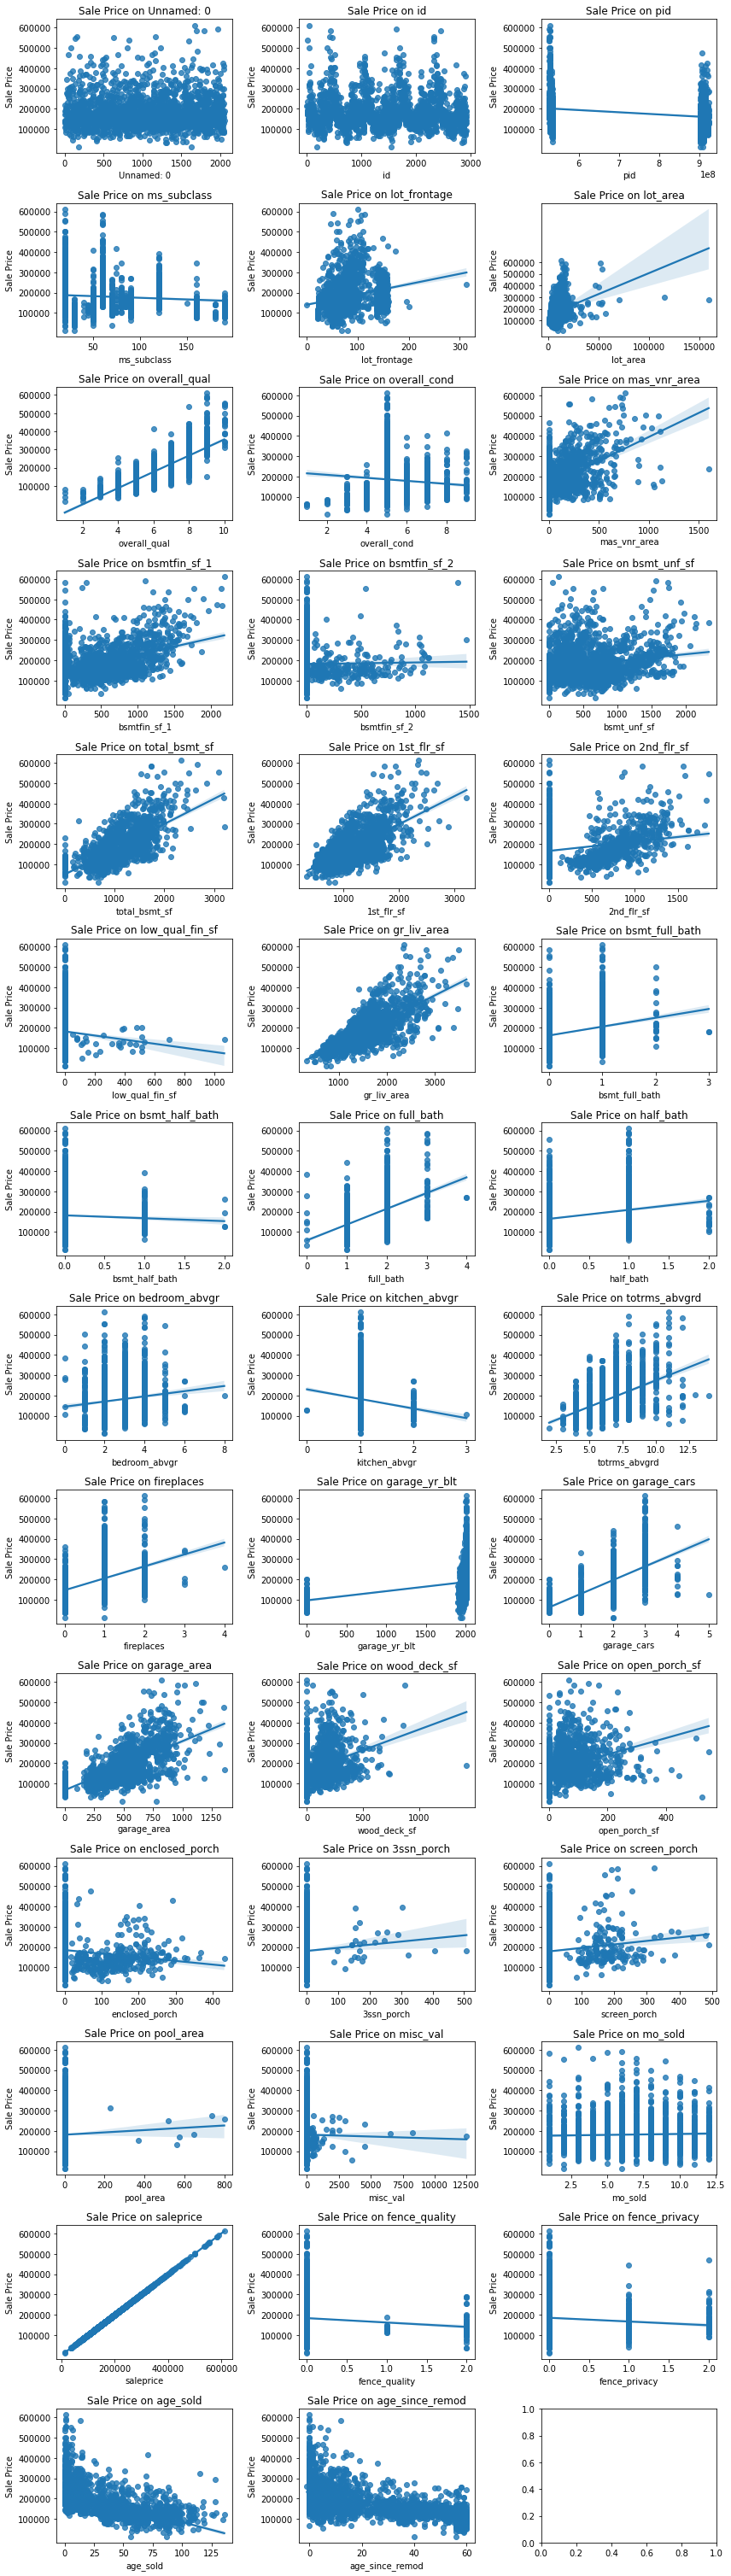

In [3]:
# Let us once again analyze our scatter plots to see if we can uncover any findings

columns = train_df.select_dtypes(['int','float']).columns

rows = int(np.ceil(len(columns)/3))

fig, ax = plt.subplots(rows,3,figsize= (12,3*rows))

ax = ax.ravel()

for i,column in enumerate(columns):
    sns.regplot(data=train_df,x = columns[i], y =train_df['saleprice'],ax=ax[i])
    ax[i].set_xlabel(columns[i])
    ax[i].set_ylabel('Sale Price')
    ax[i].set_title('Sale Price'+ ' on ' + columns[i])
    ax[i].set_yticks(np.arange(100000, 700000, step=100000))

fig.tight_layout()

### Analysis

Inspecting the scatter plots, we observe that there seems to be a clear positive linear relationship between area and sale price. This includes features such as Ground Living Area and Total Basement Square Feet. This is in line with common belief as buyers will prefer bigger houses with more space.

We observe that the age of the house has a negative relationship with sale price. Not only is this the case for the year the house was built, but also the age since it was remodelled/had new additions. This is also logical as buyers will prefer newer houses rather than old ones. 

We should however note that Overall Condition of the house does not have a clear linear relationship with sale price. In fact, we can see that it is slightly downward sloping, indicating a slight negative relationship. This abnormality is not reflected for overall quality of the house, as we observe that the better the material, and finish of the house, the higher the sale price.

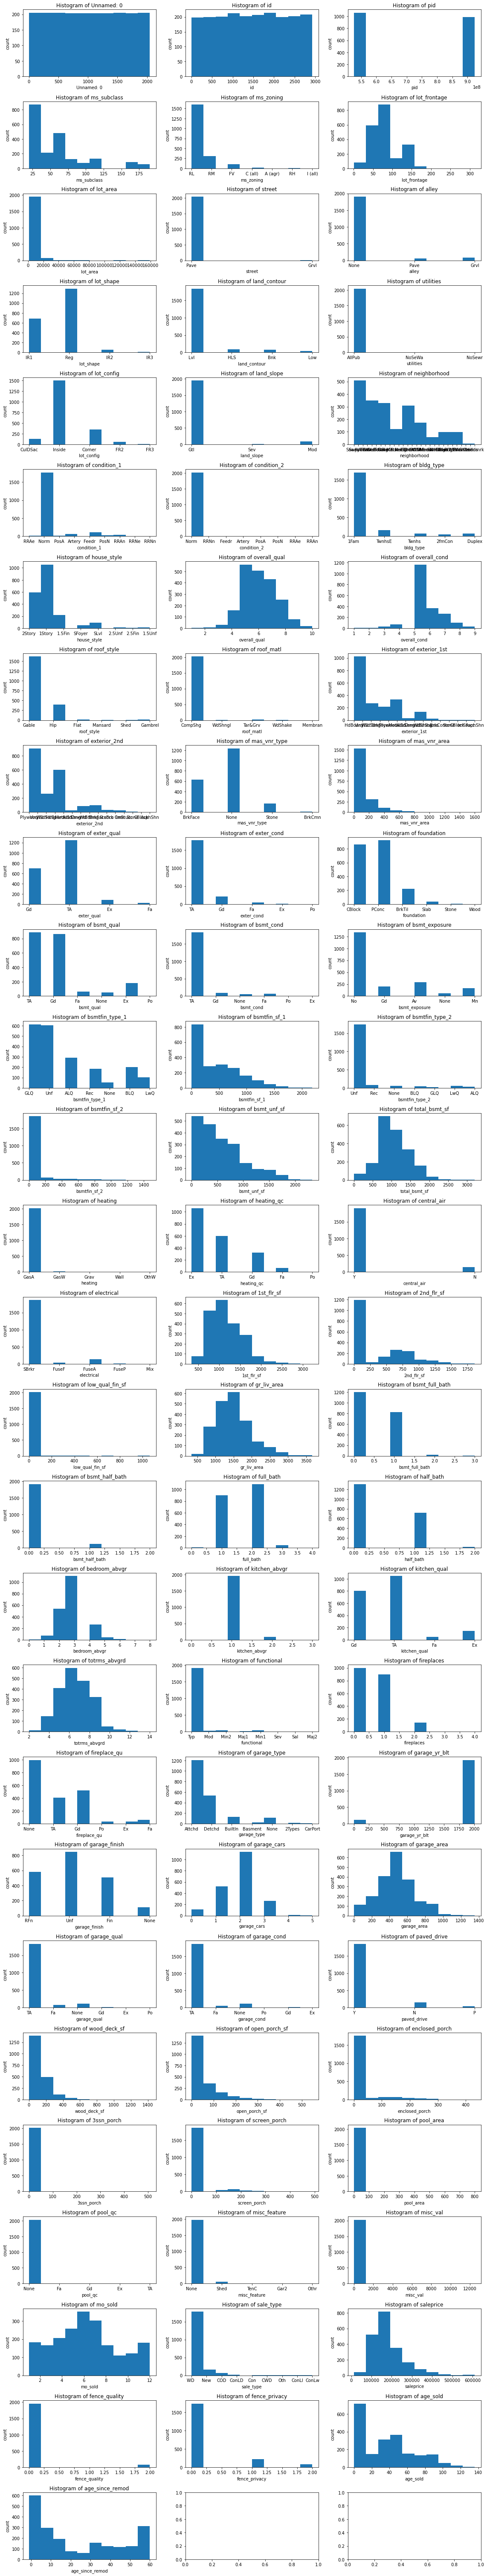

In [4]:
#Plotting out histograms

hist_columns = train_df.columns
    
rows = int(np.ceil(len(hist_columns)/3))
    
fig, ax = plt.subplots(rows,3, figsize = (16,3*rows))
        
ax = ax.ravel()
    
for i, column in enumerate(hist_columns):
        ax[i].hist(train_df[column])
        
        ax[i].set_xlabel(str(column))
        ax[i].set_ylabel('count')
        
        ax[i].set_title(f'Histogram of {str(column)}')
        
        plt.plot
        
fig.tight_layout()

### Analysis

When inspecting the histogram plots of our features, we see that many of the size features such as Ground Living Area tend to be skewed right. Our dependent variable, sale price is also skewed right. Variables that indicate quality such as Overall Quality are usually skewed left, indicating that most houses are perceived to be of decent quality.

We can however see that features such as Pool Area, Pool Quality and Miscallaneous Value which have very low variance as they seem to be clustered around the same value. On closer inspection, we identify that they seem to consist of zero values. Hence, we will sieve out such features and drop them.

In [5]:
# Create mask from original dataframe to find all variables with more than 75% zero values 

zero_series = train_df.isin([0]).sum().sort_values(ascending=False)
zero_series = zero_series[zero_series > 0.75*len(train_df)]
display(zero_series)

# Dropping features with low counts
train_df.drop(zero_series.index.tolist(),axis=1,inplace=True)
test_df.drop(zero_series.index.tolist(),axis=1,inplace=True)

pool_area          2037
3ssn_porch         2019
low_qual_fin_sf    2013
misc_val           1981
fence_quality      1955
bsmt_half_bath     1920
screen_porch       1865
bsmtfin_sf_2       1798
fence_privacy      1738
enclosed_porch     1719
dtype: int64

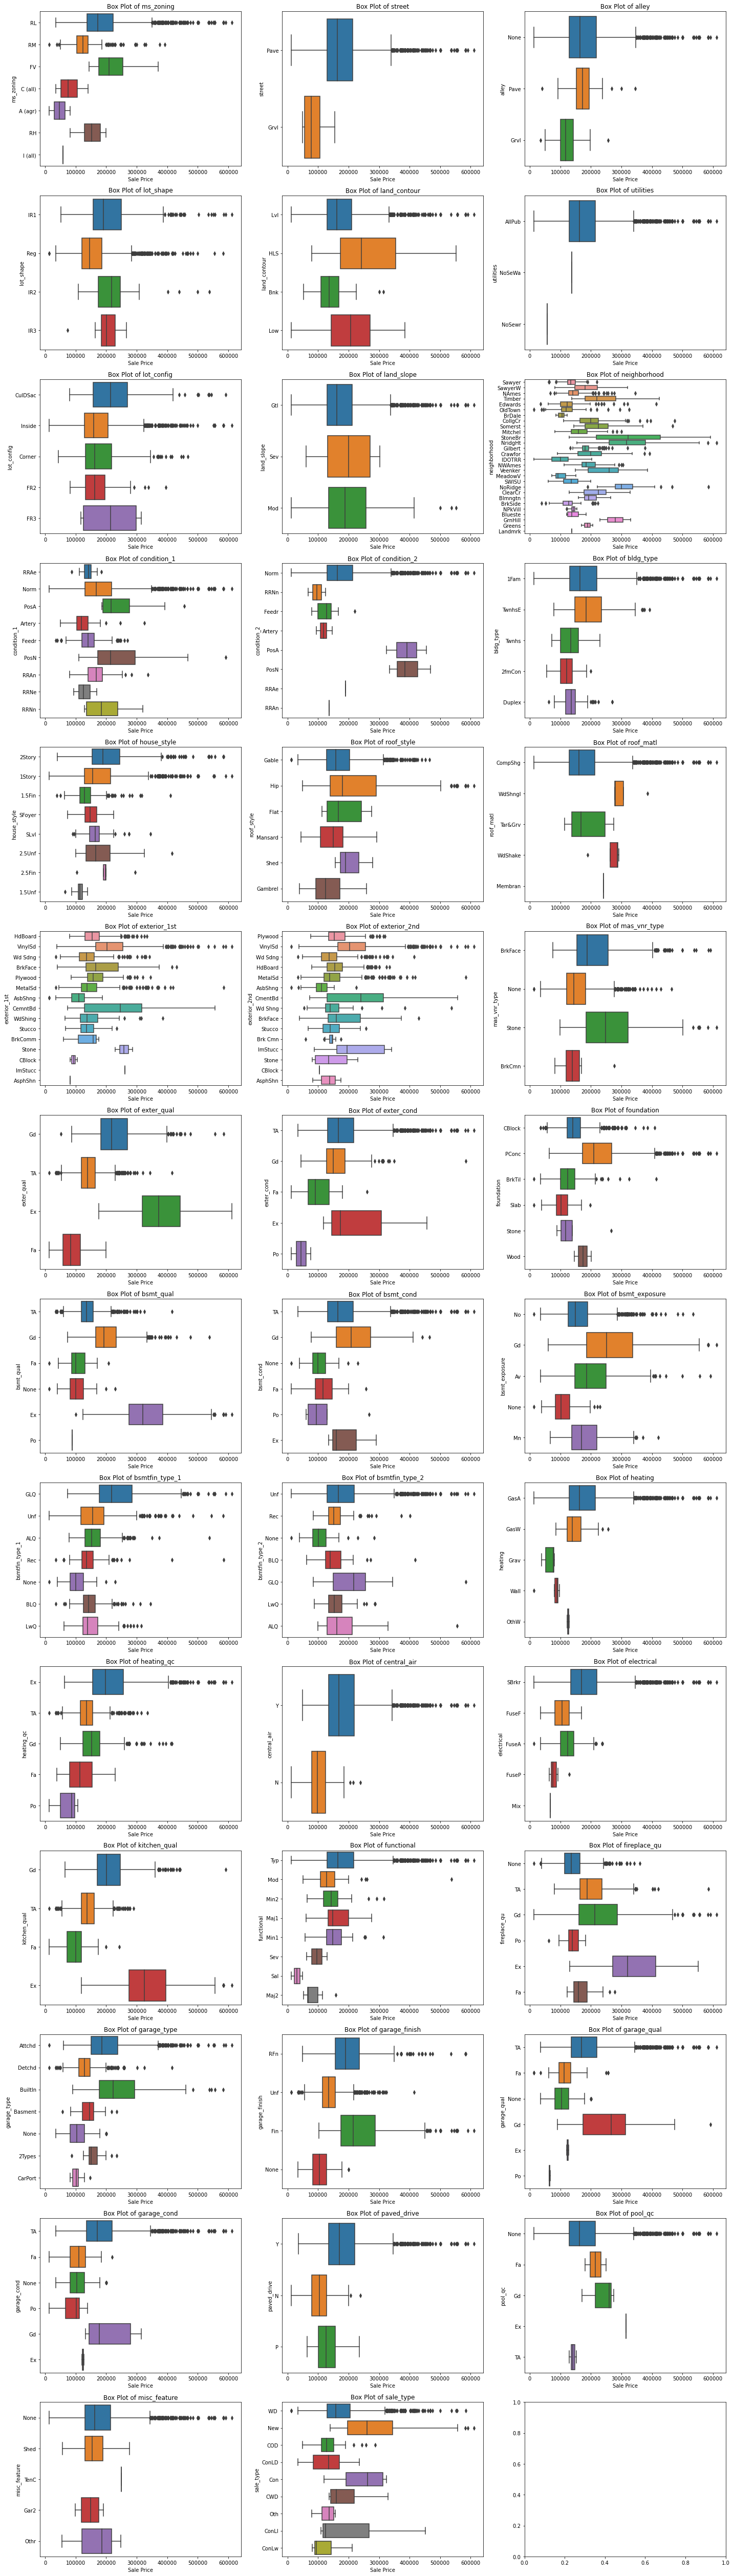

In [6]:
# Box plots of categorical features
cat_col = train_df.select_dtypes(include=['object']).columns.to_list()

rows = int(np.ceil(len(cat_col)/3))

fig, ax = plt.subplots(nrows=rows, ncols=3, figsize = (20,5*rows))
ax = ax.ravel()

for i, column in enumerate(cat_col):
    sns.boxplot(data=train_df, x='saleprice', y=cat_col[i], ax=ax[i], orient='h')

    ax[i].set_ylabel(str(column))
    ax[i].set_xlabel('Sale Price')

    ax[i].set_title(f'Box Plot of {str(column)}')

plt.tight_layout()

### Analysis

Through analyzing the boxplots, it is clear that better quality also results in higher sale prices, as can be seen for the boxplot of kitchen quality where we see s steady rise from fair to excellent. This is also seen for exterior quality as well. It thus seems that quality is indeed an important feature to be considered.

Moreover, we can also see that certain types of foundation seems to be valued much more highly than others, such as Concrete, which exceeds others not only for the median, but also interquartile range.

As the neighborhoods boxplot is rather cluttered, let us plot it out and analyze it further.

Text(0.5, 1.0, 'Box Plot of Neighborhoods on Sale Price')

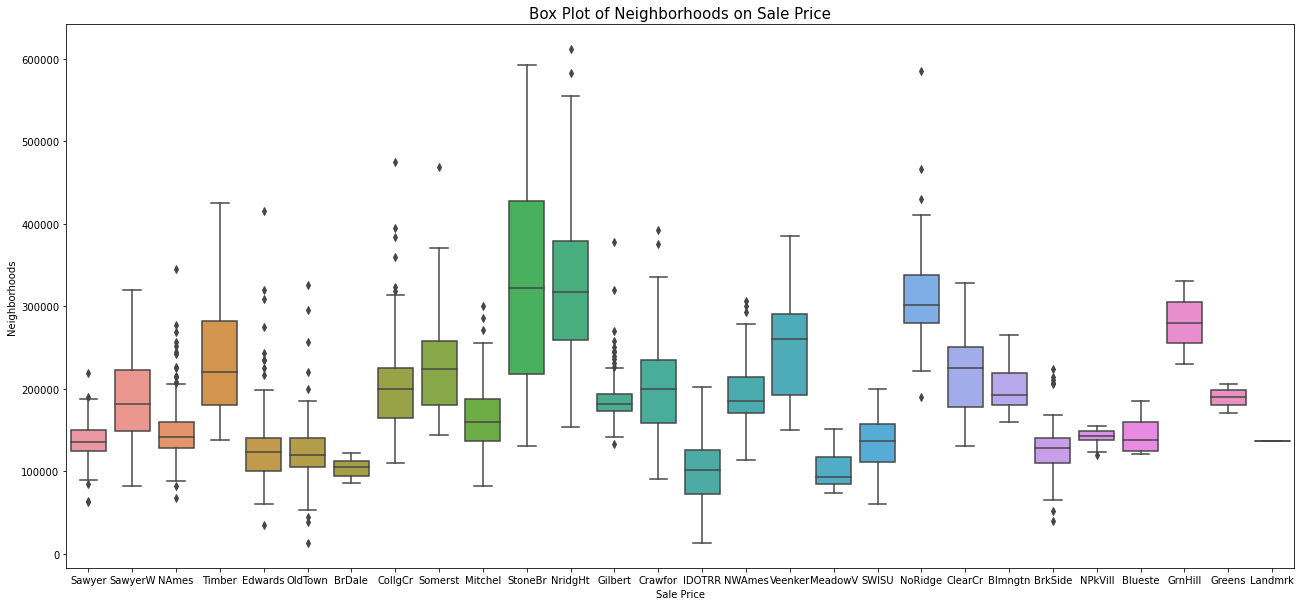

In [7]:
# Plotting of neighbourhoods on Sale Price

plt.figure(figsize = (22,10))

sns.boxplot(data=train_df, x='neighborhood', y='saleprice')

plt.ylabel('Neighborhoods')
plt.xlabel('Sale Price')
plt.title(f'Box Plot of Neighborhoods on Sale Price',fontsize = 15)

### Analysis

We can see that there different neighborhoods have different impact on sale prices. The median price of houses in Stone Brook and Northridge Heights seem to be much higher than the rest of the neighborhoods. Further research shows that the income of Stone Brooks far outweighs the general Ames population <sup> 1 </sup>. Moreover, 75% of the workforce in Northridge Heights are white collar workers, indicating higher wealth <sup> 2 </sup>. We hence can see that houses in wealthier neighborhoods seem to be able to sell for higher prices.

In [8]:
# We will need to encode the ordinal features for linear regression
ord_col = ['lot_shape', 'utilities', 'land_slope', 'exter_qual', 
               'exter_cond', 'bsmt_qual','bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1',
               'bsmtfin_type_2', 'heating_qc','electrical','kitchen_qual','functional', 'fireplace_qu', 
               'garage_finish', 'garage_qual', 'garage_cond', 'paved_drive','pool_qc','fence_quality','fence_privacy']

train_df.replace({'lot_shape':{'Reg':4,'IR1':3,'IR2':2,'IR3':1}, 
 'utilities':{'AllPub':4,'NoSewr':3,'NoSeWa':2,'ELO':1},
 'land_slope':{'Gtl':3,'Mod':2,'Sev':1},
 'exter_qual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
 'exter_cond':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
 'bsmt_qual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0},
 'bsmt_cond':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0},
 'bsmt_exposure':{'Gd':4,'Av':3,'Mn':2,'No':1,'None':0},
 'bsmtfin_type_1':{'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'None':0},
 'bsmtfin_type_2':{'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'None':0},
 'heating_qc':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
 'electrical' : {'SBrkr' : 5, 'FuseA' : 4, 'FuseF' : 3, 'FuseP' : 2, 'Mix' : 1},
 'kitchen_qual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
 'functional':{'Typ':8,'Min1':7,'Min2':6,'Mod':5,'Maj1':4,'Maj2':3,'Sev':2,'Sal':1},
 'garage_finish':{'Fin':3,'RFn':2,'Unf':1,'None':0},
 'garage_qual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0},
 'garage_cond':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0},
 'paved_drive':{'Y':2,'P':1,'N':0},
 'pool_qc':{'Ex':4,'Gd':3,'TA':2,'Fa':1, 'None':0},
 'alley' : {'Grvl':1, 'Pave':1, 'None':0},
 'fireplace_qu' : {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0},
 'central_air' : {'Y':1,'N':0}
                  
                  
                  
},inplace=True)

test_df.replace({'lot_shape':{'Reg':4,'IR1':3,'IR2':2,'IR3':1}, 
 'utilities':{'AllPub':4,'NoSewr':3,'NoSeWa':2,'ELO':1},
 'land_slope':{'Gtl':3,'Mod':2,'Sev':1},
 'exter_qual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
 'exter_cond':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
 'bsmt_qual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0},
 'bsmt_cond':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0},
 'bsmt_exposure':{'Gd':4,'Av':3,'Mn':2,'No':1,'None':0},
 'bsmtfin_type_1':{'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'None':0},
 'bsmtfin_type_2':{'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'None':0},
 'heating_qc':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
 'electrical' : {'SBrkr' : 5, 'FuseA' : 4, 'FuseF' : 3, 'FuseP' : 2, 'Mix' : 1},
 'kitchen_qual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
 'functional':{'Typ':8,'Min1':7,'Min2':6,'Mod':5,'Maj1':4,'Maj2':3,'Sev':2,'Sal':1},
 'garage_finish':{'Fin':3,'RFn':2,'Unf':1,'None':0},
 'garage_qual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0},
 'garage_cond':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0},
 'paved_drive':{'Y':2,'P':1,'N':0},
 'pool_qc':{'Ex':4,'Gd':3,'TA':2,'Fa':1,'None':0},
 'alley' : {'Grvl':1, 'Pave':1, 'None':0},
 'fireplace_qu' : {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0},
 'central_air' : {'Y':1,'N':0}
},inplace=True)

In [9]:
# Filtering out non-numeric columns from column names to do one hot encoding

non_numeric_list = train_df.select_dtypes('object').columns

nom_list = [x for x in non_numeric_list if x not in ord_col]


In [10]:
# join train and test to ensure that test and train have same columns and that no input is not dummied
combined_df = pd.concat([train_df,test_df])

In [11]:
#One hot encoding
combined_df_2 = pd.get_dummies(columns=nom_list,data=combined_df,drop_first=True).iloc[:,1:]
combined_df_2.columns

Index(['id', 'pid', 'ms_subclass', 'lot_frontage', 'lot_area', 'alley',
       'lot_shape', 'utilities', 'land_slope', 'overall_qual',
       ...
       'misc_feature_TenC', 'sale_type_CWD', 'sale_type_Con',
       'sale_type_ConLD', 'sale_type_ConLI', 'sale_type_ConLw',
       'sale_type_New', 'sale_type_Oth', 'sale_type_VWD', 'sale_type_WD '],
      dtype='object', length=194)

In [12]:
# checking to ensure that lengths of 2 original dfs still make up the combined before splitting them
len(train_df)+len(test_df) == len(combined_df_2)

True

In [13]:
#Splitting them up again
train_df2 = combined_df_2.iloc[:len(train_df),:]
test_df2 = combined_df_2.iloc[len(train_df):,:]

In [14]:
#drop extra saleprice column that is now added to the test dataframe
test_df2.drop(['saleprice'],axis=1,inplace=True)

In [15]:
# We notice that the column Misc Feature Tennis Court is all 0 for train set except for 1 value, so we will drop it
display(train_df2['misc_feature_TenC'].value_counts())
display(test_df2['misc_feature_TenC'].value_counts())

train_df2.drop(['misc_feature_TenC'],axis=1,inplace=True)
test_df2.drop(['misc_feature_TenC'],axis=1,inplace=True)

0    2044
1       1
Name: misc_feature_TenC, dtype: int64

0    878
Name: misc_feature_TenC, dtype: int64

In [31]:
train_df2.reset_index(inplace=True,drop=True)
train_df2.to_csv('./datasets/train_df_part2.csv',index=False)

In [32]:
test_df2.reset_index(inplace=True,drop=True)
test_df2.to_csv('./datasets/test_df_part2.csv', index=False)

### Checking Homoscedacity

Before we move on to linear regression, let us check if our independent variables are homoscedastic. That means that our residuals do not have any pattern or relationship with the independent variables i.e. they should be somewhat evenly distributed. 

To do this, we should build a simple linear regression model and test the residuals through a scatterplot.

Text(0.5, 0, 'Predicted Values')

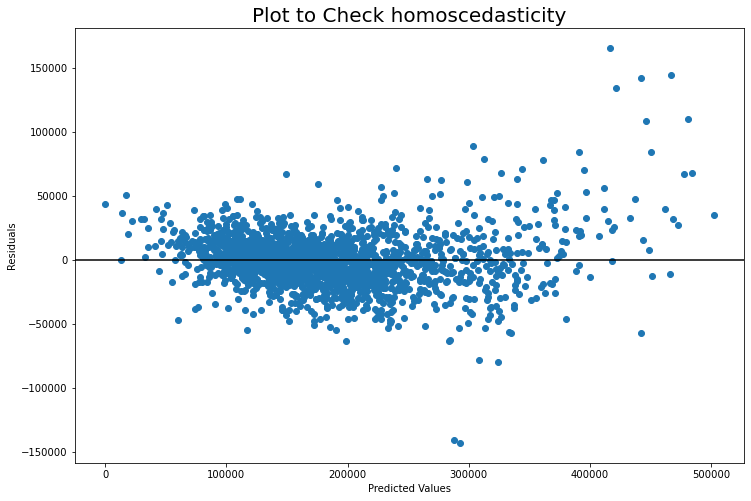

In [18]:
# Plotting residuals

x = train_df2.drop('saleprice',axis=1)
y = train_df2['saleprice']

lr = LinearRegression()

lr.fit(x,y)
y_pred = lr.predict(x)

plt.figure(figsize=(12,8))
plt.scatter(x=y_pred, y=y-y_pred)
plt.axhline(y=0, c = 'black')
plt.title('Plot to Check homoscedasticity', fontsize=20)
plt.ylabel('Residuals')
plt.xlabel('Predicted Values')

### Analysis

We can see from our plot that the residuals are distributed fairly across the values of independent variables. Hence, we can infer that our residual variance is somewhat constant and our data is homoscedastic. Before we move on to building our linear models, let us try to find the top correlated features.

[Text(0.5, 1.0, 'Heatmap of features against saleprice')]

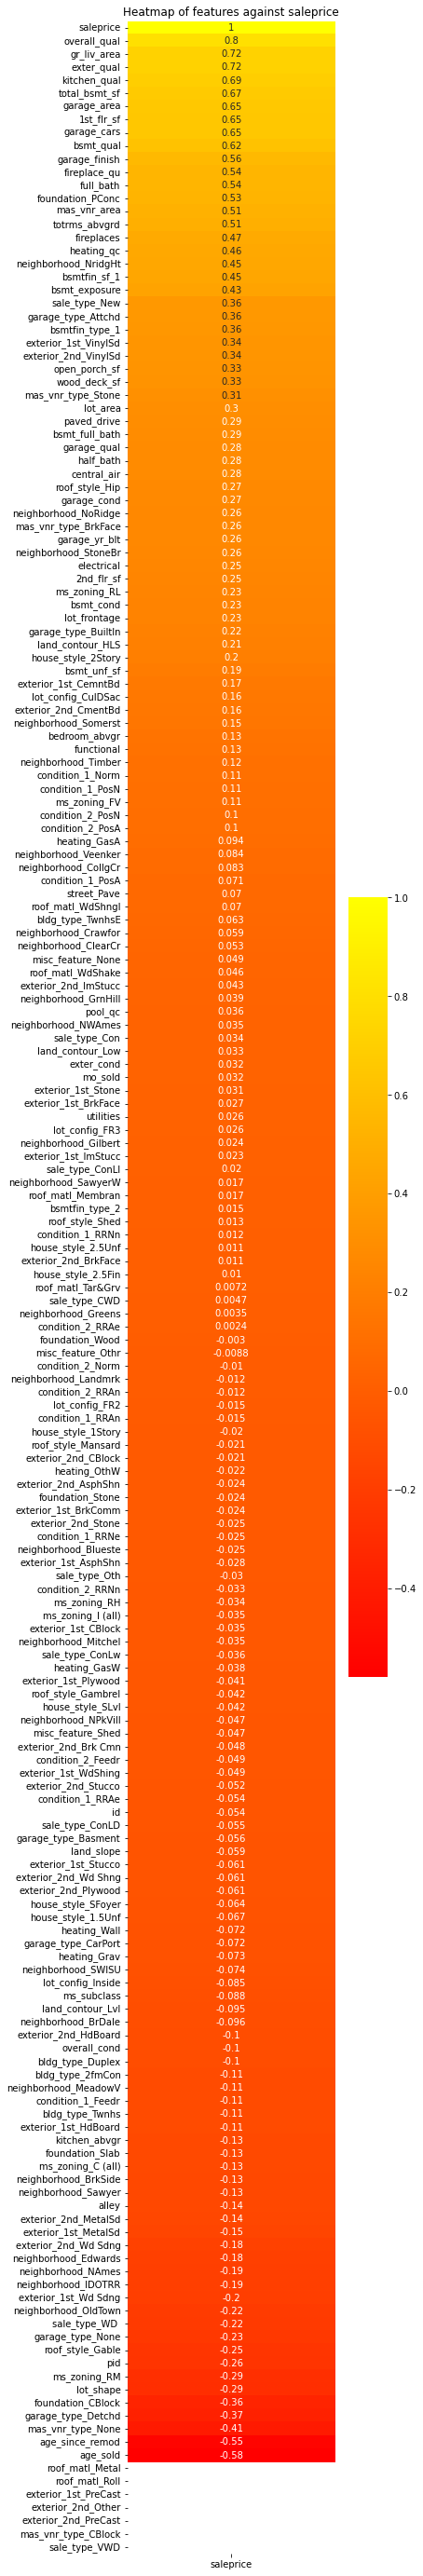

In [19]:
# Plotting heatmap to check colinearity
plt.figure(figsize=(5,50))

sns.heatmap(train_df2.corr()[['saleprice']].sort_values('saleprice',ascending=False),
            annot=True,cmap = 'autumn').set(title = 'Heatmap of features against saleprice')

In [20]:
# checking on the number of features that have more than 50% correlation

heat_df = train_df2.corr()[['saleprice']].sort_values('saleprice',ascending=False)

display(f'Number of highly positively correlated features: {len(heat_df.loc[heat_df["saleprice"]>0.5])}')
display(f'Number of highly negatively correlated features: {len(heat_df.loc[heat_df["saleprice"]<-0.5])}')

'Number of highly positively correlated features: 16'

'Number of highly negatively correlated features: 2'

In [21]:
# Displaying the columns with high positive correlation
heat_df.loc[heat_df['saleprice']>0.5]

,saleprice
saleprice,1.000
overall_qual,0.803
gr_liv_area,0.719
exter_qual,0.717
kitchen_qual,0.693
total_bsmt_sf,0.670
garage_area,0.655
1st_flr_sf,0.652
garage_cars,0.648
bsmt_qual,0.622


In [22]:
# Displaying the columns with high negative correlation
heat_df.loc[heat_df['saleprice']<-0.5]

,saleprice
age_since_remod,-0.553
age_sold,-0.580


### Analysis 

Many features measuring quality have a very high correlation with sale price, followed by features that measure area.

Only 2 features have higher than 50% negative correlation - age since remodifications were done/added and age sold. We thus see that buyers do care about how old the house is. The term old is gold does not seem to bode well for houses.

In [23]:
# Creating a list of features as our indepedent variables

features_list = ['overall_qual','gr_liv_area','exter_qual','kitchen_qual',
                 'total_bsmt_sf','garage_area','1st_flr_sf',
                'garage_cars','bsmt_qual','garage_finish','fireplace_qu',
                'full_bath','mas_vnr_area','totrms_abvgrd',
                 'foundation_CBlock', 'foundation_PConc', 'foundation_Slab',
                'foundation_Stone', 'foundation_Wood','age_since_remod','age_sold',]

corr_features_df = train_df2[features_list]

[Text(0.5, 1.0, 'Housing Heatmap')]

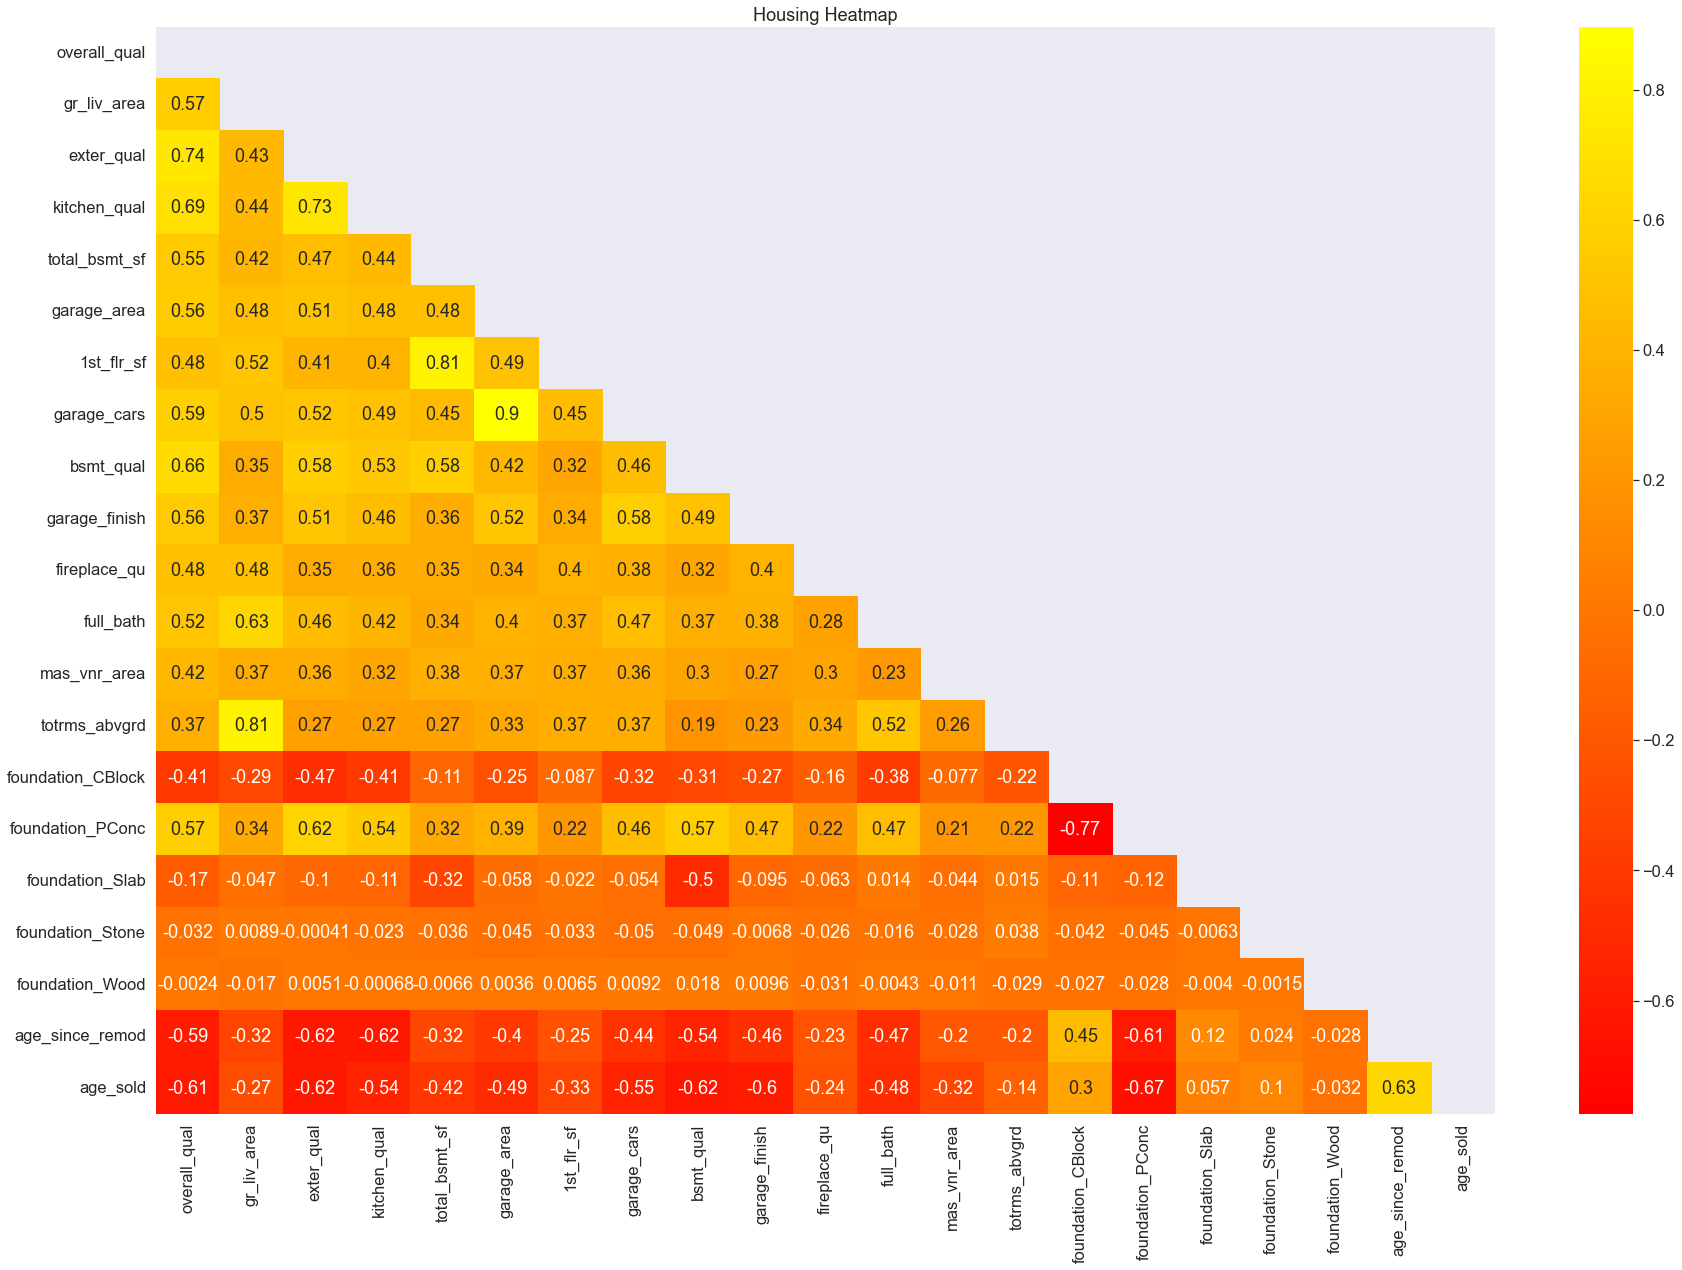

In [24]:
plt.figure(figsize=(30, 20))
sns.set(font_scale= 1.5)

mask = np.zeros_like(corr_features_df.corr())
mask[np.triu_indices_from(mask)]=True
sns.heatmap(corr_features_df.corr(),mask = mask, annot=True,cmap = 'autumn').set(title = 'Housing Heatmap')

In [25]:
# Identifying features that have high multicolinearity

heatmap_corr_df =corr_features_df.corr()

high_heat_1 = heatmap_corr_df[(heatmap_corr_df>0.8) & (heatmap_corr_df<1)].unstack()
high_heat_2 = high_heat_1.sort_values(ascending = False)
high_heat_2.head(10)

garage_area    garage_cars     0.897
garage_cars    garage_area     0.897
total_bsmt_sf  1st_flr_sf      0.810
1st_flr_sf     total_bsmt_sf   0.810
gr_liv_area    totrms_abvgrd   0.810
totrms_abvgrd  gr_liv_area     0.810
overall_qual   overall_qual      NaN
               gr_liv_area       NaN
               exter_qual        NaN
               kitchen_qual      NaN
dtype: float64

### Analysis

Looking at the heat map above, we can observe that some features like Garage Area, Garage Cards, total basement sq feet, 1st floor sq ft, Ground Living Area and Total Rooms Above Grade have a high level of multicollinearity.

Having too many correlated features may cause our model to become very sensitive to small changes, thus introducing high variance. Moreover, multicollinearity reduces the precision of the estimated coefficients, which weakens the statistical power of our  model. We will do a second test, the Variance Inflation Factor (VIF) to affirm our believes that there exists multicolinearity between these factors.

In [26]:
#VIF test with statsmodel

dep_var = sm.add_constant(corr_features_df)

series_1 = pd.Series([variance_inflation_factor(dep_var.values,i) for i in range (dep_var.shape[1])],
                     index=dep_var.columns) 

series_1_df = pd.DataFrame(series_1,columns = ['VIF'])

series_1_df.loc[series_1_df['VIF']>6]

,VIF
const,217.954
garage_cars,6.252
foundation_PConc,6.208


In [27]:
#Dropping garage cars from our list of features for our model as showed by 
#both heatmap and VIF to have high multicollinearity
corr_features_df.drop(['garage_cars'],axis=1,inplace=True)

In [34]:
corr_features_df.to_csv('./datasets/corr_features_df_part2.csv',index=False)

### Analysis

We can see that 'garage cars' is once again identified as a feature with high multicolinearity as it has a high VIF value of 6.252. Looking at the descriptive abstract from the Readme file, we see that 'garage cars' is the size of garage in car capacity. Hence, it is highly similar to 'garage area' and should be dropped from our indepedent features list. Now that our EDA is done, let us move on to model building.


## Outside Research

1. https://statisticalatlas.com/neighborhood/Iowa/Ames/Stone-Brooke/Household-Income

   Summary: The source displays graphs that show how Stone Brook had a higher household income at each percentile as compared to the general Ames population.
   
   
2. https://www.weichert.com/search/community/neighborhood.aspx?hood=60290

   Summary: The article displayed graphs which show that 75% of the workforce in NorthRidge Heights were white collar jobs, indicating higher wealth.